In [ ]:
import os
import numpy as np
import skimage as ski
import torch
import pandas as pd
import torchvision
from rembg import remove, new_session
import matplotlib.pyplot as plt    
import seaborn as sb
from sklearn import metrics
import scipy.stats as stats
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters # I think this is also missing in requirements.txt
os.chdir("..")

# Initialize the bgremove session
bg_session = new_session()

# Define the species arrays and the italicized versions for plotting
species_array = ['aegypti', 'albopictus', 'annulipes-group', 'caspius',
       'cataphylla', 'cinereus-geminus-pair', 'claviger-petragnani-pair',
       'communis-punctor-pair', 'japonicus', 'koreicus',
       'maculipennis s.l.', 'modestus', 'morsitans-fumipennis-pair',
       'other', 'pipiens s.l.-torrentium-pair', 'richiardii', 'rusticus',
       'stephensi', 'sticticus', 'vexans', 'vishnui-group']

species_italic = ['$\\it{Ae. aegypti}$','$\\it{Ae. albopictus}$',
                  '$\\it{Ae. japonicus}$','$\\it{Ae. koreicus}$',
                  '$\\it{An. maculipennis}$ s.l.','other',
                  '$\\it{Cx. torrentium-pipiens\\ }$s.l. pair',
                  '$\\it{Cq. richiardii}$','$\\it{An. stephensi}$',
                  '$\\it{Ae. vexans}$','$\\it{Cx. vishnui}$-group']

predict_italic = ['$\\it{Ae. aegypti}$','$\\it{Ae. albopictus}$',
                  '$\\it{Ae. japonicus}$','$\\it{Ae. koreicus}$',
                  '$\\it{An. maculipennis}$ s.l.','other',
                  '$\\it{Cx. torrentium-pipiens\\ }$s.l. pair',
                  '$\\it{Cq. richiardii}$','$\\it{An. stephensi}$',
                  '$\\it{Ae. vexans}$','$\\it{Cx. vishnui}$-group', '$\\it{Ae. caspius}$']

ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
# Many of the following functions here are duplicates to analyse_feasibility_zeiss-device.ipynb
# I would suggest to move them into a python file and then load them from there -> makes it easier to follow the notebook
# I just saw that they are also in BALROG_pipeline.py -> why not load from there

In [ ]:
# Pipeline function to preprocess the images
def find_files_with_extension(directory, extension):
    file_path_ls = []

    # Walk through the directory tree and collect matching files
    for dirpath, _, filenames in os.walk(directory):
        for filename in filenames:
            if filename.endswith(extension):
                file_path_ls.append(os.path.join(dirpath, filename))

    # Extract just filenames (not full paths)
    file_name_ls = [os.path.basename(file_path) for file_path in file_path_ls]

    return file_path_ls, file_name_ls


def remove_bg_and_rotate(image, bg_session):
    # Remove the background (transparent background)
    image_rembg = remove(image, bgcolor=(0, 0, 0, -1), session=bg_session)
    mask = np.asarray(image_rembg)[:, :, 3] > 10  # Mask where alpha > 10

    # Apply the mask to the image to retain only foreground
    image_masked = image_rembg * np.dstack([mask] * 4)

    # Get orientation from region properties
    properties = ski.measure.regionprops_table(ski.measure.label(mask), properties=("axis_major_length", "orientation"))
    angle = -(properties["orientation"][np.argmax(properties["axis_major_length"])] * (180 / np.pi) + 90)
    angle = angle + 180 if angle < -90 else angle  # Normalize the angle to a valid range

    # Rotate the image and mask based on the calculated angle
    rotated_image = ski.transform.rotate(image_masked, angle, resize=False, mode='edge', preserve_range=True)
    rotated_mask = ski.transform.rotate(mask, angle, resize=False, mode='edge', preserve_range=True)

    # Remove empty rows and columns (crop the image to the non-empty region)
    rows = np.any(rotated_mask, axis=1)
    cols = np.any(rotated_mask, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    # Crop the image and mask to the bounding box of non-empty regions
    image_cropped = rotated_image[rmin:rmax, cmin:cmax]
    mask_cropped = rotated_mask[rmin:rmax, cmin:cmax]

    # Return the cropped image and mask (exclude alpha channel from the image)
    return image_cropped[:, :, :3], mask_cropped


def CLAHE_transform(image, clip_limit=0.5, nbins=32):
    # Convert image to grayscale and apply CLAHE
    equalized_img = ski.exposure.equalize_adapthist(np.mean(image, axis=-1), clip_limit=clip_limit, nbins=nbins)
    equalized_img = ski.filters.median(equalized_img, ski.morphology.disk(1))
    return torch.tensor(equalized_img, dtype=torch.float32)


def pad_and_resize(image):
    # Pad the image to make it square, with the longer dimension being the target size
    height, width = image.shape[:2]
    max_dim = max(height, width)
    pad_height = (max_dim - height) // 2
    pad_width = (max_dim - width) // 2
    image_padded = torch.nn.functional.pad(image, (pad_width, pad_width, pad_height, pad_height), mode='constant', value=0)

    # Resize the image to 512x512, then crop to the desired region
    image_resized = torchvision.transforms.functional.resize(image_padded.unsqueeze(0), (512, 512)).numpy()[0]
    return image_resized[128:384, :]


def image_preprocessing_pipeline(file_path, bg_session):
    # Load image
    image = ski.io.imread(file_path)

    # Remove background, rotate the image, and get the mask
    image, mask = remove_bg_and_rotate(image, bg_session)

    # Apply CLAHE transformation
    image = CLAHE_transform(image / 255)

    # Apply the mask to remove background from image
    image[~mask] = 0

    # Pad and resize the image to the specified size
    image = pad_and_resize(image)

    # Transform the image to a PyTorch tensor
    return torch.tensor(image, dtype=torch.float32).unsqueeze(0)

def get_model_prediction(model, image):
    # Convert the image to a PyTorch tensor and add batch and channel dimensions
    input = image.unsqueeze(0)

    # Get the model prediction
    with torch.no_grad():
        model.eval()
        prediction = model(input).squeeze().numpy()
    return prediction.squeeze()

In [ ]:
# Load the images and paths
images = np.load("feasibility_experiment/data/images.npy")
paths = np.load("feasibility_experiment/data/paths.npy")

# Initialize dictionaries to store models and predictions
model_dict, prediction_dict = {}, {}

# Loop through all models 
for model in os.listdir("classifier/models"):
    prediction_ls = []
    model_dict[model] = torch.load("classifier/models/{}".format(model), map_location=torch.device('cpu'))
    # Loop through all images
    for image in images:
        prediction = get_model_prediction(model_dict[model], torch.tensor(image))
        prediction_ls.append(species_array[np.argmax(prediction)])

    # Save the predictions for the model in the dictionary
    prediction_dict[model] = prediction_ls

/tmp/ipykernel_83729/3667333706.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict[model] = torch.load("classifier/models/{}".format(model), map_location=torch.

In [ ]:
# Transform the prediction dictionary to a DataFrame
dff = pd.DataFrame()
for key in prediction_dict.keys():
    df = pd.DataFrame()
    df["PRED"] = prediction_dict[key]
    df["Fold"] = key.split("_")[1]
    df["paths"] = paths

    dff = pd.concat([dff, df])

dff["file"] = dff["paths"].apply(lambda x: x.split("/")[-1])
dff["LABEL"] = dff["file"].apply(lambda x: x.split("_")[1])
dff["Participant"] = dff["paths"].apply(lambda x: x.split("/")[-2])

# Rename the image handles according to the proper LABEL
dff.loc[dff["LABEL"] == "namibi", "LABEL"] = "other"
dff.loc[dff["LABEL"] == "trit", "LABEL"] = "vishnui-group"
dff.loc[dff["LABEL"] == "pipiens", "LABEL"] = 'pipiens s.l.-torrentium-pair'
dff.loc[dff["LABEL"] == "maculipennis", "LABEL"] = 'maculipennis s.l.'
dff.loc[dff["LABEL"] == "richardii", "LABEL"] = 'richiardii'

# Create a column for correct predictions
dff["correct"] = dff["LABEL"] == dff["PRED"]

pd.to_pickle(dff, "feasibility_experiment/results/feasibility_df.pkl")

In [ ]:
# Plot the confusion matrix
DF = pd.read_pickle("feasibility_experiment/results/feasibility_df.pkl")

heatmap = pd.DataFrame()
heatmap_dict = {}
species_ls = DF["LABEL"].unique()
# Put a * in front of all species that are in column "species", for both "species and "prediction"
DF["PRED*"] = DF["PRED"].apply(lambda x: "*" + x if x in species_ls else x)
DF["LABEL*"] = DF["LABEL"].apply(lambda x: "*" + x if x in species_ls else x)
DF = DF.sort_values(by="LABEL*")
# Create the confusion matrix for each fold
for fold in DF["Fold"].unique():
    heatmap_dict[fold] = pd.crosstab(DF["LABEL*"].loc[DF["Fold"] == fold], DF["PRED*"].loc[DF["Fold"] == fold], normalize="index")

heatmap_mean = np.mean([heatmap_dict[x] for x in heatmap_dict.keys()], axis=0)*100
heatmap_std = np.std([heatmap_dict[x] for x in heatmap_dict.keys()], axis=0)*100

# Replace 0 values with "-" and values under 0.1 with "<0.1"
heatmap_mean_annot = pd.DataFrame(heatmap_mean).applymap(lambda x: "-" if x == 0 else ("<0.1" if x < 0.1 else ("100" if x == 100.0 else f"{x:.1f}")))
heatmap_mean = pd.DataFrame(heatmap_mean).applymap(lambda x: 0 if x == 0 else (0.1 if x < 0.1 else x))

fig, ax = plt.subplots(1, figsize=(10,10))
# Define the colors for the palette
colors = ["white", "#802823", "#A27942", "#326F32"]
# Create the custom palette
custom_palette = sb.blend_palette(colors, as_cmap=True)

sb.heatmap(heatmap_mean, annot=heatmap_mean_annot, fmt="", linewidth=.5, cmap=custom_palette, vmax=101, linecolor="black", cbar=False, ax=ax)

ax.spines.right.set_visible(True)
ax.spines.bottom.set_visible(True)

ax.set_yticklabels(species_italic, rotation=0)
ax.set_xticklabels(predict_italic, rotation=90)
ax.set_title("Average accuracy per species")

plt.tight_layout()



"""
When running this notebook I get an error:
{
	"name": "ValueError",
	"message": "setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (5, 11) + inhomogeneous part.",
	"stack": "---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
Cell In[5], line 15
     12 for fold in DF[\"Fold\"].unique():
     13     heatmap_dict[fold] = pd.crosstab(DF[\"LABEL*\"].loc[DF[\"Fold\"] == fold], DF[\"PRED*\"].loc[DF[\"Fold\"] == fold], normalize=\"index\")
---> 15 heatmap_mean = np.mean([heatmap_dict[x] for x in heatmap_dict.keys()], axis=0)*100
     16 heatmap_std = np.std([heatmap_dict[x] for x in heatmap_dict.keys()], axis=0)*100
     18 # Replace 0 values with \"-\" and values under 0.1 with \"<0.1\"

File ~/anaconda3/envs/mosq/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504, in mean(a, axis, dtype, out, keepdims, where)
   3501     else:
   3502         return mean(axis=axis, dtype=dtype, out=out, **kwargs)
-> 3504 return _methods._mean(a, axis=axis, dtype=dtype,
   3505                       out=out, **kwargs)

File ~/anaconda3/envs/mosq/lib/python3.12/site-packages/numpy/core/_methods.py:102, in _mean(a, axis, dtype, out, keepdims, where)
    101 def _mean(a, axis=None, dtype=None, out=None, keepdims=False, *, where=True):
--> 102     arr = asanyarray(a)
    104     is_float16_result = False
    106     rcount = _count_reduce_items(arr, axis, keepdims=keepdims, where=where)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (5, 11) + inhomogeneous part."
}
"""

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (5, 11) + inhomogeneous part.

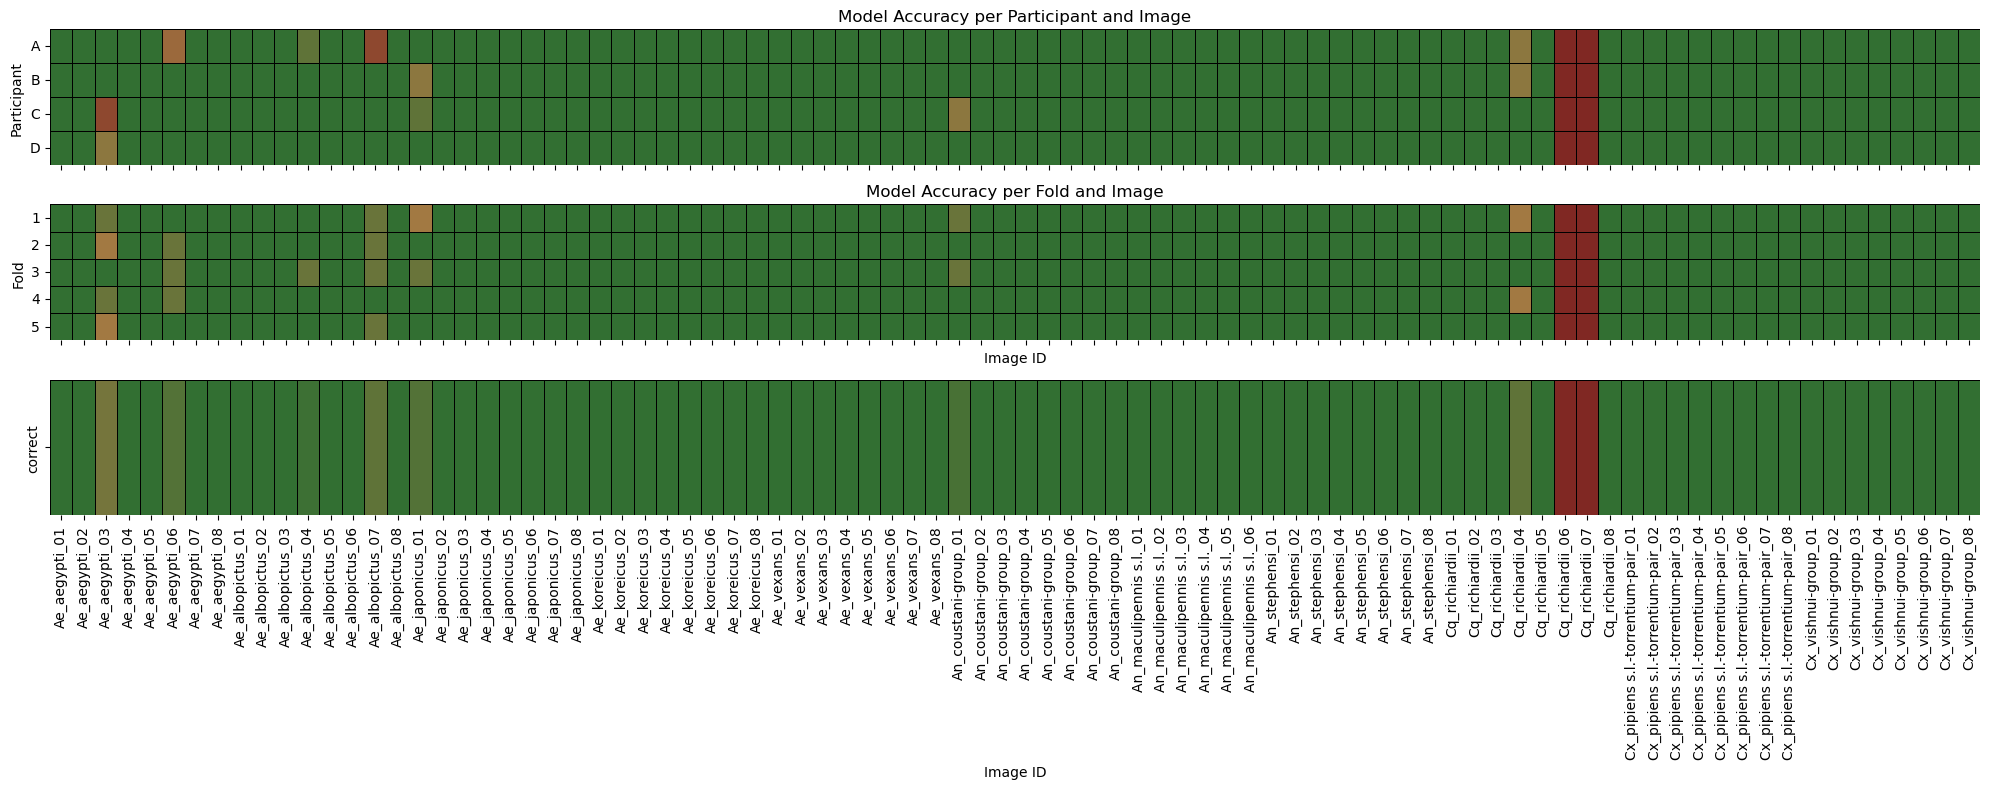

In [ ]:
# Visualize the interrater realibaility
DF["Image ID"] = [x.split(".")[0] for x in DF["file"]]
DF["Image ID"] = DF["Image ID"].str.replace("namibi", "coustani-group")
DF["Image ID"] = DF["Image ID"].str.replace("trit", "vishnui-group")
DF["Image ID"] = DF["Image ID"].str.replace("pipiens", "pipiens s.l.-torrentium-pair")
DF["Image ID"] = DF["Image ID"].str.replace("maculipennis", "maculipennis s.l.")
DF["Image ID"] = DF["Image ID"].str.replace("richardii", "richiardii")
DF["Image ID"] = DF["Image ID"].str.capitalize()

# Create a heatmap where each unique image is one column and each participant is one row, the value of each cell should be the accuracy of the model
# Create a pivot table with participants as rows, images as columns, and accuracy as values
participant_table = DF.pivot_table(index='Participant', columns="Image ID", values='correct', aggfunc='mean')
fold_table = DF.pivot_table(index='Fold', columns="Image ID", values='correct', aggfunc='mean')
sum_table = DF.pivot_table(columns="Image ID", values='correct', aggfunc='mean')

# Costum palette for the heatmap
# Define the colors for the palette
colors = ["#802823", "#A27942", "#326F32"]
# Create the custom palette
red_custom_palette = sb.blend_palette(colors, as_cmap=True)

# Plot the heatmap
fig, ax = plt.subplots(3, figsize=(20, 8), sharex=True)
sb.heatmap(participant_table, cmap=red_custom_palette, ax=ax[0], linewidth=.5, vmax=1, linecolor="black", cbar=False)
sb.heatmap(fold_table, cmap=red_custom_palette, ax=ax[1], linewidth=.5, vmax=1, linecolor="black", cbar=False)
sb.heatmap(sum_table, cmap=red_custom_palette, ax=ax[2], linewidth=.5, vmax=1, linecolor="black", cbar=False)

ax[0].set_title('Model Accuracy per Participant and Image')
ax[1].set_title('Model Accuracy per Fold and Image')
plt.xticks(rotation=90)
ax[0].set_yticklabels(["A", "B", "C", "D"], rotation=0)
ax[1].set_yticklabels(["1", "2", "3", "4", "5"], rotation=0)

ax[0].set_xlabel("")
plt.tight_layout()


In [ ]:
# Get the average balanced accuracy and F1 score for the model on the feasibility study
def get_avg_metric(df, with_ci = True):
    accuracy_ls, f1_ls = [], []
    for fold in df["Fold"].unique():
        df_fold = df.loc[df["Fold"] == fold]

        accuracy_ls.append(metrics.balanced_accuracy_score(df_fold["LABEL"], df_fold["PRED"]))
        f1_ls.append(metrics.f1_score(df_fold["LABEL"], df_fold["PRED"], average="macro"))

    acc_avg = np.mean(accuracy_ls)
    f1_avg = np.mean(f1_ls)

    if with_ci:
        acc_ci = stats.t.interval(0.95, len(accuracy_ls)-1, loc=np.mean(accuracy_ls), scale=stats.sem(accuracy_ls))
        f1_ci = stats.t.interval(0.95, len(f1_ls)-1, loc=np.mean(f1_ls), scale=stats.sem(f1_ls))
    

    return acc_avg*100, f1_avg*100, acc_ci, f1_ci

acc_avg, f1_avg, acc_ci, f1_ci = get_avg_metric(DF)
print(f"Accuracy: {acc_avg:.2f}% (95% CI: {acc_ci[0]*100:.2f}% - {acc_ci[1]*100:.2f}%)")
print(f"F1 Score: {f1_avg:.2f}% (95% CI: {f1_ci[0]*100:.2f}% - {f1_ci[1]*100:.2f}%)")

Accuracy: 96.42% (95% CI: 95.89% - 96.96%)
F1 Score: 89.33% (95% CI: 88.86% - 89.79%)


/Users/kristophernolte/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/kristophernolte/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/kristophernolte/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/kristophernolte/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/kristophernolte/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr

In [ ]:
# Calculate Fleiss Kappa
df_sum = DF.sort_values(by="Image ID")
interrater_matrix = [list(df_sum.loc[df_sum["Participant"] == "joy", "PRED"]),
                     list(df_sum.loc[df_sum["Participant"] == "kristopher", "PRED"]),
                     list(df_sum.loc[df_sum["Participant"] == "sara", "PRED"]),
                     list(df_sum.loc[df_sum["Participant"] == "hannes", "PRED"])]
interrater_matrix = pd.DataFrame(interrater_matrix).T
agg_matrix = aggregate_raters(interrater_matrix)
fleiss_kappa(agg_matrix[0], method='fleiss')

0.973227627428192